In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD

No handles with labels found to put in legend.


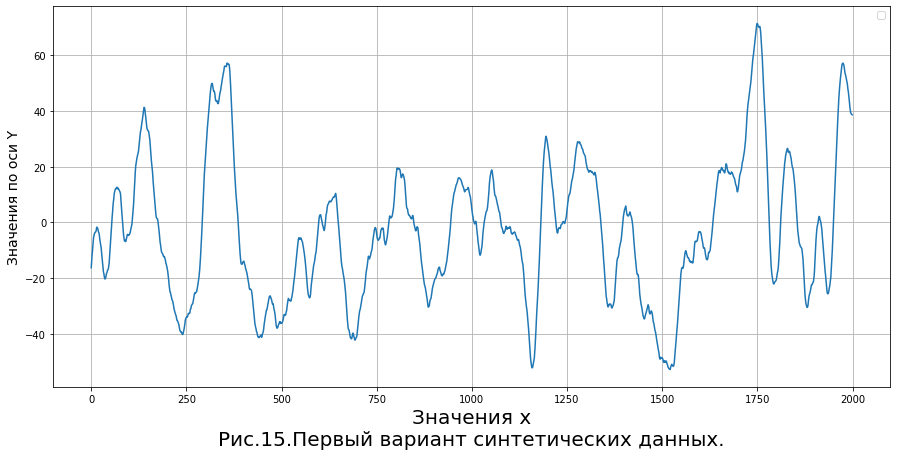

In [ ]:
n = 2000  # Длина ряда y
window = 60   # Ширина окна 

np.random.seed(2)

# Синтетические данные:
m = np.random.randn(n + window - 1)
y = np.zeros(n)

a1 = [i / window for i in range(window // 2)]
a2 = [1 - i / window for i in range(window // 2, window)]
a = a1 + a2
for i in range(n):
    for j in range(window):
        y_add = 10 * a[j] * m[window - 1 + i - j]
        y[i] += y_add

#Визуализация данных
plt.figure(figsize=(15,7))
plt.xlabel('Значения x\nРис.15.Первый вариант синтетических данных.', fontsize=20)
plt.ylabel('Значения по оси Y', fontsize=14)
plt.plot(y)
plt.legend()
plt.grid()
plt.show()
num_shape = int(n * 0.9)

In [ ]:
#размер тренировочного датасета
train = np.array(y[:num_shape]).reshape(-1, 1)
test = np.array(y[num_shape:]).reshape(-1, 1)

#изменяем масштаб тренировочных данных(нормализация данных)
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [ ]:
# сейчас получим данные, которые будут поданы в нейронную сеть
X_train = []
y_train = []
for i in range(window, num_shape):
    X_train_add = train_scaled[i-window:i] #ширина окна = window, получаем вектор-столбец windowх1 
    X_train.append(X_train_add)          # список из векторов-столбцов windowх1
    y_train.append(train_scaled[i])   # добавляется 31 точка тренировочного датасета(ее прогнозируем)
X_train = np.stack(X_train) # объединяем все массивы из одного элемента в один массив
y_train = np.stack(y_train) # объединяем все массивы из одного элемента в один массив

In [ ]:
# Initializing the Recurrent Neural Network
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape = (window, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1)) #последовательная модель
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_43 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_43 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_44 (Dropout)        (None, 50)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# обучаем модель
model.compile(optimizer = 'SGD', loss = 'mean_squared_error') # лосс функция - MSE, мы ее минимизируем.
model.fit(X_train, y_train, epochs = 1000, batch_size = 32); # epochs отвечают за длительность обучения(100 итераций)
# batch_size делит данные на пакеты, т.е вместо подачи одного вектора 30x1 на вход будет подано сразу несколько векторов. 

In [ ]:
 #загоняем тестовые данные в нашу обученную модель
new_y = np.vstack((train, test)) #объединяем в один массив трениров и тест данные 

inputs = new_y[new_y.shape[0] - test.shape[0] - window:] #для проверки контрольных данных нам требуется 0.1 * num_shape - window значений.
#0.1 num_shape vectors with size (window, 1) => 0.1 num_shape predicted dots
inputs = sc.transform(inputs) #нормализация данных
num_2 = new_y.shape[0] - num_shape + window

X_test = [] #y

for i in range(window, num_2):
    X_test_add = inputs[i-window:i]
    X_test.append(X_test_add) #0.1 num_shape vectors with size(window, 1)
#Тестовые данные - список массивов с 30 значениями. Каждый массив подается на вход нейронной сети и предсказываются значения в точках 181, 182, ..., 199
X_test = np.stack(X_test) #переводим в нампаевский массив

In [ ]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict) #scaled to default values

In [ ]:
diff = predict - test

print("MSE:", np.mean(diff**2))

MSE: 13.38912739345647


In [ ]:
predurok = predict.copy()

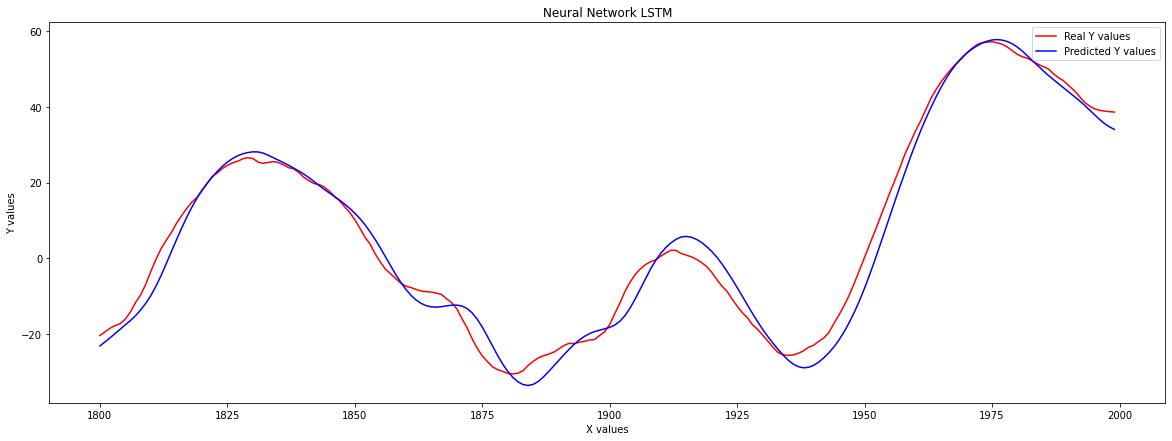

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(range(num_shape, len(y)), y[num_shape:], color = 'red', label = 'Real Y values')
plt.plot(range(num_shape, len(y)), predurok, color = 'blue', label = 'Predicted Y values')
plt.title('Neural Network LSTM')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.show()

In [ ]:
new_predictions = []
number_of_preds = 100
first_input = X_test.copy()
onepredict = model.predict(first_input)[-1]
input_add = np.vstack((first_input[-1][1:], onepredict))
input = np.vstack((first_input[1:], input_add.reshape(-1, window, 1)))
onepredict = sc.inverse_transform(onepredict.reshape(-1, 1))
new_predictions.append(onepredict[0][0])

In [ ]:
for j in range(number_of_preds - 1):
    onepredict = model.predict(input)[-1]
    input_add = np.vstack((input[-1][1:], onepredict))
    input = np.vstack((input[1:], input_add.reshape(-1, window, 1)))
    onepredict = sc.inverse_transform(onepredict.reshape(-1, 1))
    new_predictions.append(onepredict[0][0])

In [ ]:
prediction_full_new1 = []
for elem in predurok:
    prediction_full_new1.append(elem[0])
prediction_full_new1.extend(new_predictions)

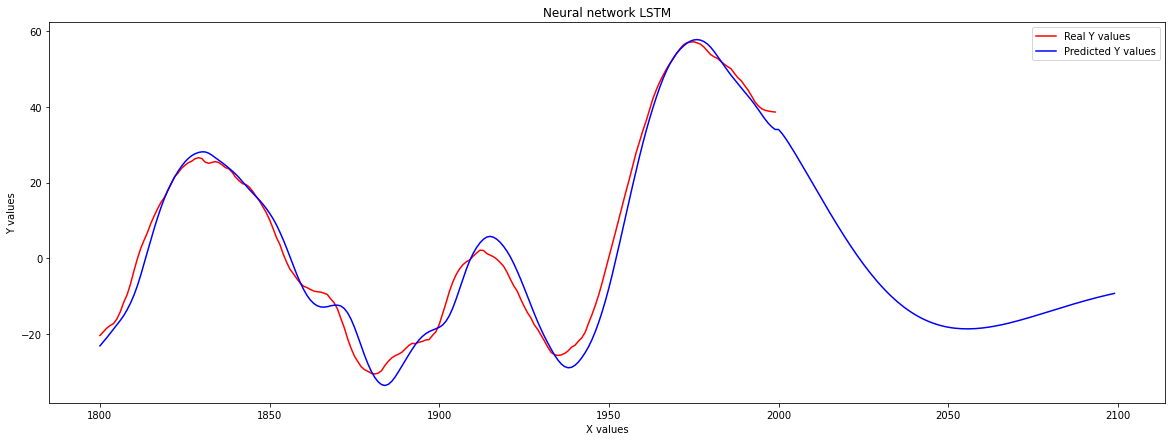

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(range(num_shape, len(y)), y[num_shape:], color = 'red', label = 'Real Y values')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new1, color = 'blue', label = 'Predicted Y values')
plt.title('Neural network LSTM')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.show()

will_be_used_2 = prediction_full_new1.copy()

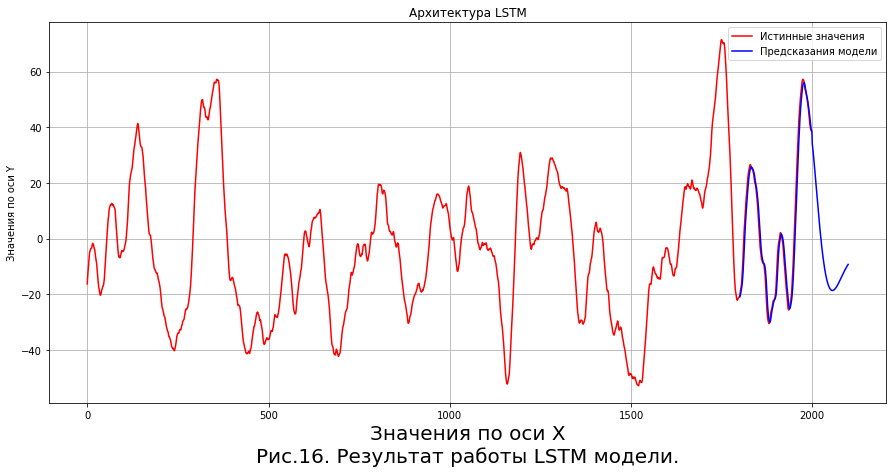

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(len(y)), y, color = 'red', label = 'Истинные значения')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new1, color = 'blue', label = 'Предсказания модели')
plt.title('Архитектура LSTM')
plt.xlabel('Значения по оси X\nРис.16. Результат работы LSTM модели.', fontsize=20)
plt.ylabel('Значения по оси Y')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(window, 1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 60, 50)            7950      
                                                                 
 dropout_52 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_10 (GRU)                (None, 50)                15300     
                                                                 
 dropout_53 (Dropout)        (None, 50)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelGRU.compile(optimizer='SGD', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=1000, batch_size=32)

In [ ]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

In [ ]:
diff = predict - test
print("MSE:", np.mean(diff**2))

MSE: 15.583692791543312


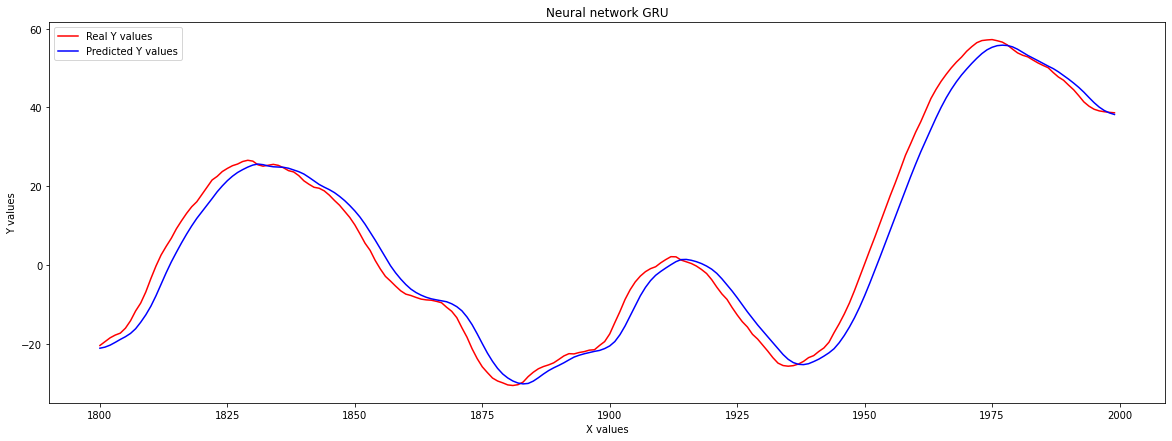

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(range(num_shape, len(y)), y[num_shape:], color = 'red', label = 'Real Y values')
plt.plot(range(num_shape, len(y)), predict, color = 'blue', label = 'Predicted Y values')
plt.title('Neural network GRU')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.show()

In [ ]:
new_predictions = []
number_of_preds = 100
first_input = X_test.copy()
onepredict = modelGRU.predict(first_input)[-1]
input_add = np.vstack((first_input[-1][1:], onepredict))
input = np.vstack((first_input[1:], input_add.reshape(-1, window, 1)))
onepredict = sc.inverse_transform(onepredict.reshape(-1, 1))
new_predictions.append(onepredict[0][0])

In [ ]:
for j in range(number_of_preds - 1):
    onepredict = modelGRU.predict(input)[-1]
    input_add = np.vstack((input[-1][1:], onepredict))
    input = np.vstack((input[1:], input_add.reshape(-1, window, 1)))
    onepredict = sc.inverse_transform(onepredict.reshape(-1, 1))
    new_predictions.append(onepredict[0][0])

In [ ]:
prediction_full_new = []
for elem in predict:
    prediction_full_new.append(elem[0])
prediction_full_new.extend(new_predictions)

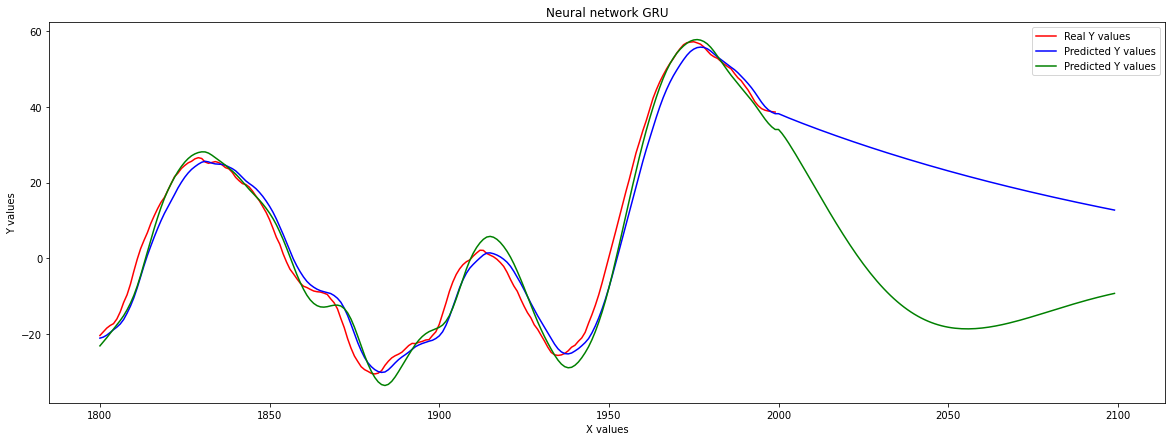

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(range(num_shape, len(y)), y[num_shape:], color = 'red', label = 'Real Y values')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new, color = 'blue', label = 'Predicted Y values')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new1, color = 'green', label = 'Predicted Y values')
plt.title('Neural network GRU')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.show()


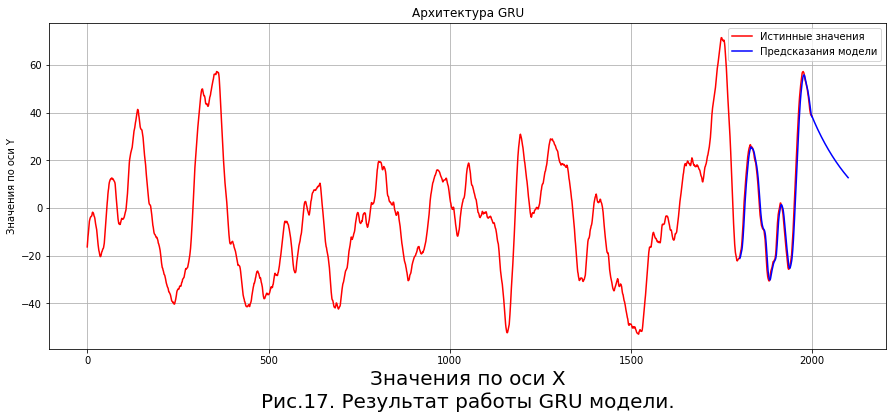

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(range(len(y)), y, color = 'red', label = 'Истинные значения')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new, color = 'blue', label = 'Предсказания модели')
plt.title('Архитектура GRU')
plt.xlabel('Значения по оси X\nРис.17. Результат работы GRU модели.', fontsize=20)
plt.ylabel('Значения по оси Y')
plt.grid()
plt.legend()
plt.show()

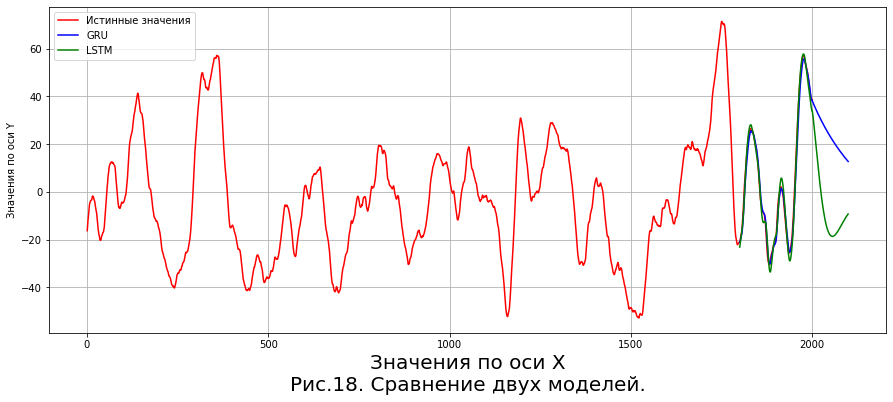

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(range(1, len(y) + 1), y, color = 'red', label = 'Истинные значения')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new, color = 'blue', label = 'GRU')
plt.plot(range(num_shape, len(y) + number_of_preds), will_be_used_2, color = 'green', label = 'LSTM')
plt.xlabel('Значения по оси X\nРис.18. Сравнение двух моделей.', fontsize=20)
plt.ylabel('Значения по оси Y')
plt.grid()
plt.legend()
plt.show()

In [ ]:
prediction_full_new[-1]

-9.290942

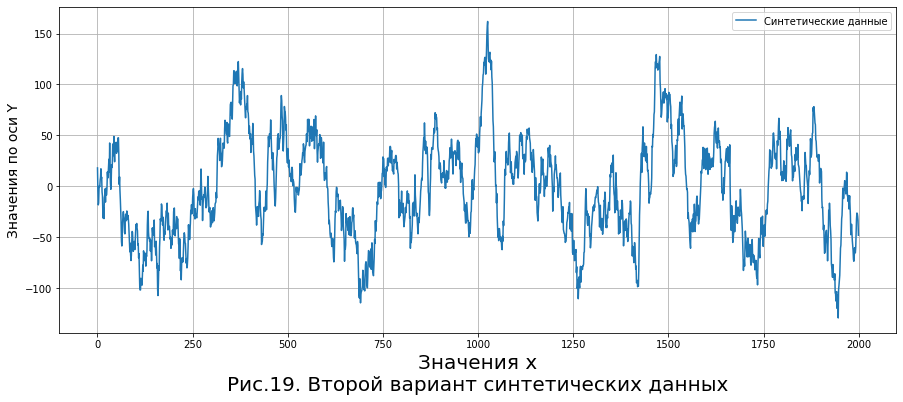

In [ ]:
np.random.seed(1000)

n = 2000  # Длина ряда y
window = 60   # Ширина окна 

m = np.random.randn(n + window - 1)
y = np.zeros(n)
a = [1 - i / window for i in range(window)]

for i in range(n):
    for j in range(window):
        y_add = 10 * a[j] * m[window - 1 + i - j]
        y[i] += y_add

#Визуализация данных
plt.figure(figsize=(15,6))
plt.xlabel('Значения x\nРис.19. Второй вариант синтетических данных', fontsize=20)
plt.ylabel('Значения по оси Y', fontsize=14)
plt.plot(y, label='Синтетические данные')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#размер тренировочного датасета
num_shape = int(n * 0.9)

train = np.array(y[:num_shape]).reshape(-1, 1) # y.shape = (199, ), reshape(-1, 1) = reshape(len(y), 1)
test = np.array(y[num_shape:]).reshape(-1, 1)
#изменяем масштаб тренировочных данных(нормализация данных)
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

# сейчас получим данные, которые будут поданы в нейронную сеть
X_train = []
y_train = []
for i in range(window, num_shape):
    X_train_add = train_scaled[i-window:i] #ширина окна = window, получаем вектор-столбец windowх1 
    X_train.append(X_train_add)          # список из векторов-столбцов windowх1
    y_train.append(train_scaled[i])   # добавляется 31 точка тренировочного датасета(ее прогнозируем)
X_train = np.stack(X_train) # объединяем все массивы из одного элемента в один массив
y_train = np.stack(y_train) # объединяем все массивы из одного элемента в один массив

In [ ]:
# Initializing the Recurrent Neural Network
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape = (window, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1)) #последовательная модель
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_54 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_45 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_55 (Dropout)        (None, 50)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# обучаем модель
model.compile(optimizer = 'SGD', loss = 'mean_squared_error') # лосс функция - MSE, мы ее минимизируем.
model.fit(X_train, y_train, epochs = 1000, batch_size = 32); # epochs отвечают за длительность обучения(100 итераций)
# batch_size делит данные на пакеты, т.е вместо подачи одного вектора 30x1 на вход будет подано сразу несколько векторов. 

In [ ]:
 #загоняем тестовые данные в нашу обученную модель
new_y = np.vstack((train, test)) #объединяем в один массив трениров и тест данные 

inputs = new_y[new_y.shape[0] - test.shape[0] - window:] #для проверки контрольных данных нам требуется 0.1 * num_shape - window значений.
#0.1 num_shape vectors with size (window, 1) => 0.1 num_shape predicted dots
inputs = sc.transform(inputs) #нормализация данных
num_2 = new_y.shape[0] - num_shape + window

X_test = [] #y

for i in range(window, num_2):
    X_test_add = inputs[i-window:i]
    X_test.append(X_test_add) #0.1 num_shape vectors with size(window, 1)
#Тестовые данные - список массивов с 30 значениями. Каждый массив подается на вход нейронной сети и предсказываются значения в точках 181, 182, ..., 199
X_test = np.stack(X_test) #переводим в нампаевский массив

In [ ]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict) #scaled to default values

In [ ]:
diff = predict - test
print("MSE:", np.mean(diff**2))

MSE: 237.26561171927656


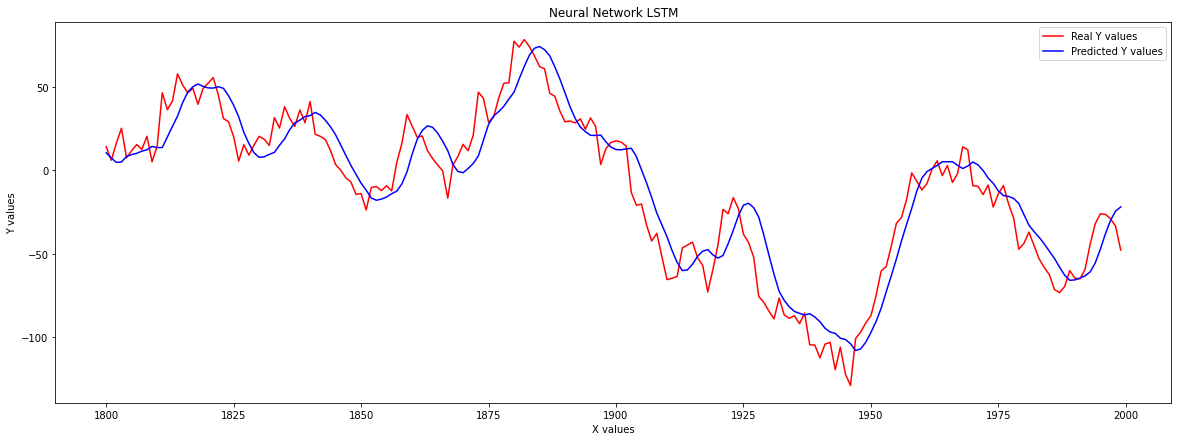

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(range(num_shape, len(y)), y[num_shape:], color = 'red', label = 'Real Y values')
plt.plot(range(num_shape, len(y)), predict, color = 'blue', label = 'Predicted Y values')
plt.title('Neural Network LSTM')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.show()

In [ ]:
new_predictions = []
number_of_preds = 100
first_input = X_test.copy()
onepredict = model.predict(first_input)[-1]
input_add = np.vstack((first_input[-1][1:], onepredict))
input = np.vstack((first_input[1:], input_add.reshape(-1, window, 1)))
onepredict = sc.inverse_transform(onepredict.reshape(-1, 1))
new_predictions.append(onepredict[0][0])

In [ ]:
for j in range(number_of_preds - 1):
    onepredict = model.predict(input)[-1]
    input_add = np.vstack((input[-1][1:], onepredict))
    input = np.vstack((input[1:], input_add.reshape(-1, window, 1)))
    onepredict = sc.inverse_transform(onepredict.reshape(-1, 1))
    new_predictions.append(onepredict[0][0])

In [ ]:
prediction_full_new1 = []
for elem in predict:
    prediction_full_new1.append(elem[0])
prediction_full_new1.extend(new_predictions)

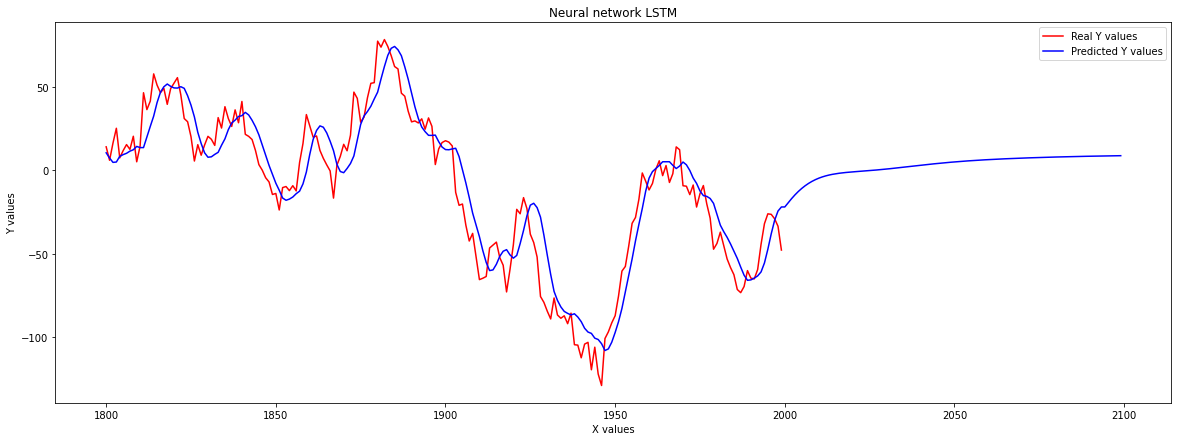

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(range(num_shape, len(y)), y[num_shape:], color = 'red', label = 'Real Y values')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new1, color = 'blue', label = 'Predicted Y values')
plt.title('Neural network LSTM')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.show()

will_be_used_2 = prediction_full_new1.copy()

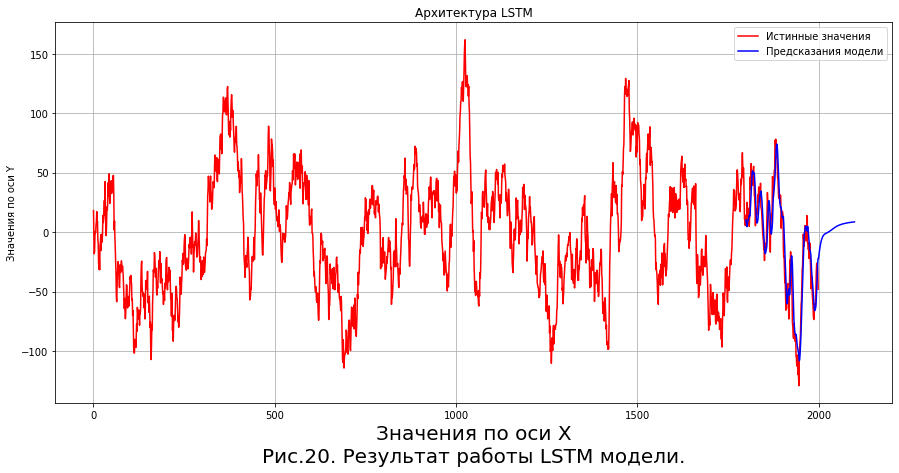

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(len(y)), y, color = 'red', label = 'Истинные значения')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new1, color = 'blue', label = 'Предсказания модели')
plt.title('Архитектура LSTM')
plt.xlabel('Значения по оси X\nРис.20. Результат работы LSTM модели.', fontsize=20)
plt.ylabel('Значения по оси Y')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(window, 1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 60, 50)            7950      
                                                                 
 dropout_56 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_12 (GRU)                (None, 50)                15300     
                                                                 
 dropout_57 (Dropout)        (None, 50)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 51        
                                                                 
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelGRU.compile(optimizer='SGD', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=1000, batch_size=32)

In [ ]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

In [ ]:
diff = predict - test
print("MSE:", np.mean(diff**2))

MSE: 145.09081298086815


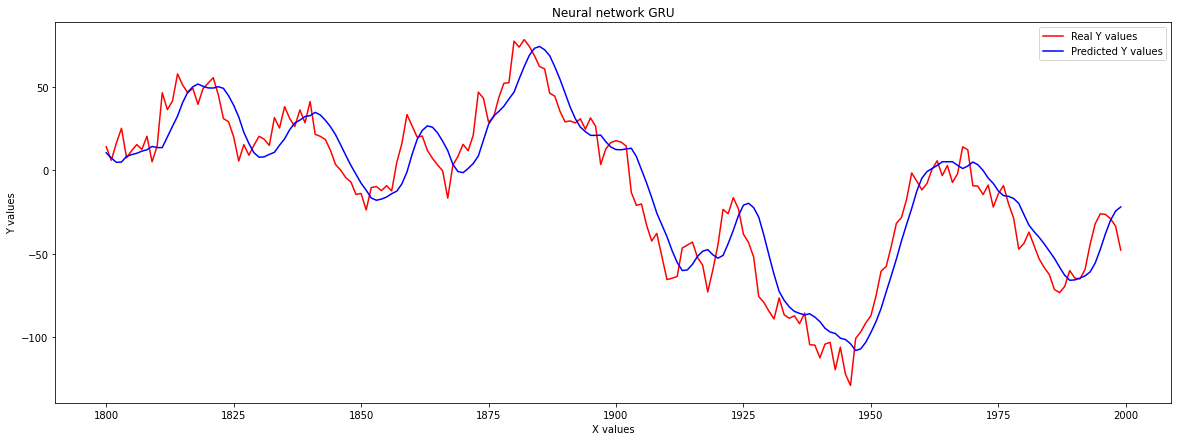

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(range(num_shape, len(y)), y[num_shape:], color = 'red', label = 'Real Y values')
plt.plot(range(num_shape, len(y)), predict, color = 'blue', label = 'Predicted Y values')
plt.title('Neural network GRU')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.show()

In [ ]:
new_predictions = []
number_of_preds = 100
first_input = X_test.copy()
onepredict = modelGRU.predict(first_input)[-1]
input_add = np.vstack((first_input[-1][1:], onepredict))
input = np.vstack((first_input[1:], input_add.reshape(-1, window, 1)))
onepredict = sc.inverse_transform(onepredict.reshape(-1, 1))
new_predictions.append(onepredict[0][0])

In [ ]:
for j in range(number_of_preds - 1):
    onepredict = modelGRU.predict(input)[-1]
    input_add = np.vstack((input[-1][1:], onepredict))
    input = np.vstack((input[1:], input_add.reshape(-1, window, 1)))
    onepredict = sc.inverse_transform(onepredict.reshape(-1, 1))
    new_predictions.append(onepredict[0][0])

In [ ]:
prediction_full_new = []
for elem in predict:
    prediction_full_new.append(elem[0])
prediction_full_new.extend(new_predictions)

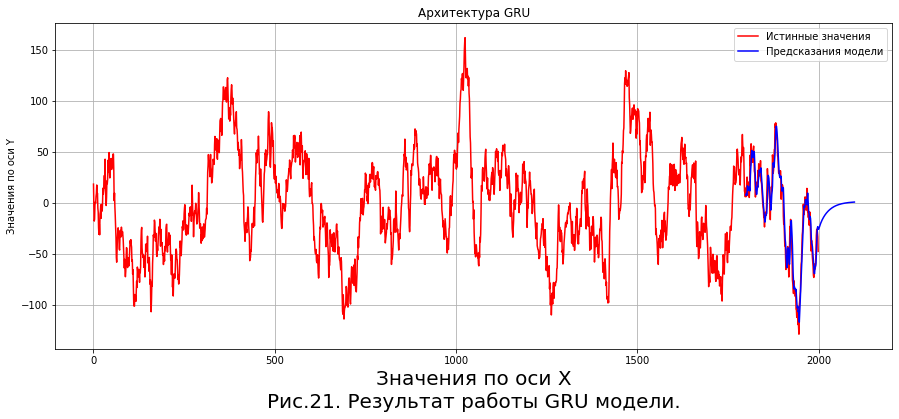

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(range(len(y)), y, color = 'red', label = 'Истинные значения')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new, color = 'blue', label = 'Предсказания модели')
plt.title('Архитектура GRU')
plt.xlabel('Значения по оси X\nРис.21. Результат работы GRU модели.', fontsize=20)
plt.ylabel('Значения по оси Y')
plt.grid()
plt.legend()
plt.show()

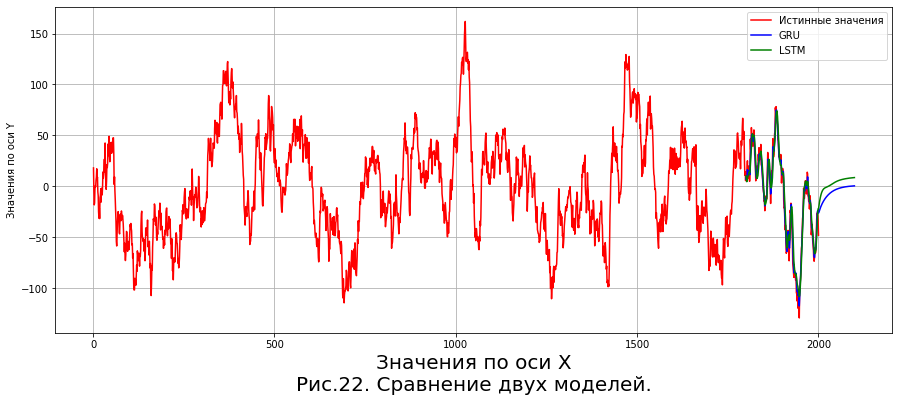

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(range(1, len(y) + 1), y, color = 'red', label = 'Истинные значения')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new, color = 'blue', label = 'GRU')
plt.plot(range(num_shape, len(y) + number_of_preds), prediction_full_new1, color = 'green', label = 'LSTM')
plt.xlabel('Значения по оси X\nРис.22. Сравнение двух моделей.', fontsize=20)
plt.ylabel('Значения по оси Y')
plt.grid()
plt.legend()
plt.show()